In [1]:
import os, sys, math, json, random, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa, soundfile as sf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import roc_auc_score, roc_curve

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


In [2]:
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Project paths
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
CACHE_DIR = PROJECT_ROOT / "outputs" / "cache_fc"
ARTIFACTS_DIR = PROJECT_ROOT / "outputs" / "artifacts"
for p in [CACHE_DIR, ARTIFACTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

Device: cuda


In [3]:
# Experiment config
MACHINE = "fan"         # fan, pump, slider, valve, toycar, toyconveyor
TARGET_FPR = 0.10       # Neyman–Pearson target false positive rate

# Audio + features
SR = 16000
N_FFT = 1024
HOP = 512
N_MELS = 128

# Frame stacking for FC input
FRAME_STACK = 5         # number of consecutive frames per vector
# Input dimension = N_MELS * FRAME_STACK

# Training
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 10
VAL_SPLIT = 0.1
PATIENCE = 8

# Optional labels CSV for AUC
LABELS_CSV = None  # CSV with columns [path,label] where label in {0,1}; leave None to skip AUC

In [4]:
def list_wavs(machine: str):
    """
    Return two lists of wav Paths for the given machine.
    train contains only normal sounds.
    test contains a mix of normal and anomalies.
    """
    train = sorted((DATA_DIR / machine / "train").glob("*.wav"))
    test  = sorted((DATA_DIR / machine / "test").glob("*.wav"))
    return train, test

train_paths, test_paths = list_wavs(MACHINE)
print(f"Machine: {MACHINE}")
print(f"Train files: {len(train_paths)}")
print(f"Test files:  {len(test_paths)}")
print("Example train file:", train_paths[0].name if train_paths else "N/A")
print("Example test file: ", test_paths[0].name if test_paths else "N/A")

assert len(train_paths) > 0 and len(test_paths) > 0, "Missing audio. Check data paths."

Machine: fan
Train files: 3675
Test files:  1875
Example train file: normal_id_00_00000000.wav
Example test file:  anomaly_id_00_00000000.wav


In [5]:
def wav_to_logmel(path: Path, sr=SR, n_fft=N_FFT, hop=HOP, n_mels=N_MELS) -> np.ndarray:
    """
    Load mono audio. Compute log-Mel spectrogram in dB.
    Returns [n_mels, T] float32.
    """
    y, sr0 = librosa.load(path, sr=None, mono=True)
    if sr0 != sr:
        y = librosa.resample(y, orig_sr=sr0, target_sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

def stack_frames(mel_db: np.ndarray, n_frames: int) -> np.ndarray:
    """
    Turn [M, T] Mel into [N, M*n_frames] stacked vectors using a sliding window.
    Pads on the right if T < n_frames.
    """
    M, T = mel_db.shape
    if T < n_frames:
        pad = np.tile(mel_db[:, -1:], (1, n_frames - T))
        mel_db = np.concatenate([mel_db, pad], axis=1)
        T = mel_db.shape[1]

    X = []
    for i in range(T - n_frames + 1):
        win = mel_db[:, i:i+n_frames]           # [M, n_frames]
        X.append(win.reshape(M * n_frames))     # [M*n_frames]
    return np.stack(X, axis=0).astype(np.float32)  # [N, D]

def cache_mel_if_needed(path: Path) -> Path:
    """
    Save Mel spectrogram to cache as .npy if not cached yet.
    Returns path to the .npy file.
    """
    out = CACHE_DIR / f"{path.stem}_mel.npy"
    if not out.exists():
        mel = wav_to_logmel(path)
        np.save(out, mel)
    return out

# Quick preview to confirm preprocessing works
_preview_cache = cache_mel_if_needed(train_paths[0])
_preview_mel = np.load(_preview_cache)
print("Preview Mel:", _preview_mel.shape)                    # [n_mels, T]
print("Stacked shape:", stack_frames(_preview_mel, FRAME_STACK).shape)  # [N, D]

Preview Mel: (128, 313)
Stacked shape: (309, 640)


In [6]:
class FCFramesDataset(Dataset):
    """
    Dataset that yields stacked Mel-frame vectors for a fully-connected autoencoder.

    Train:
      - uses normal train files only
      - computes feature-wise mean/std on a subset for normalization

    Test:
      - uses test files for scoring
      - uses mean/std from training via set_norm(mean, std)
    """
    def __init__(self, paths, frame_stack_n=FRAME_STACK, train=True):
        self.paths = list(paths)
        self.fs = frame_stack_n
        self.train = train

        self.index = []           # list of (file_idx, segment_idx)
        self.file_segments = []   # number of segments per file (for per-file aggregation)
        for fi, p in enumerate(tqdm(self.paths, desc="Precompute segments")):
            mel_path = cache_mel_if_needed(p)
            mel = np.load(mel_path)
            seg = stack_frames(mel, self.fs)     # [N, D]
            self.file_segments.append(len(seg))
            for si in range(len(seg)):
                self.index.append((fi, si))

        # Dimension after stacking
        self.input_dim = N_MELS * self.fs

        # Compute normalization on a random subset of train vectors
        if self.train:
            total = len(self.index)
            sample_idxs = np.random.choice(total, min(20000, total), replace=False)
            Xs = []
            for idx in sample_idxs:
                fi, si = self.index[idx]
                mel = np.load(CACHE_DIR / f"{self.paths[fi].stem}_mel.npy")
                Xs.append(stack_frames(mel, self.fs)[si])
            Xs = np.stack(Xs, 0)         # [K, D]
            self.mean = Xs.mean(0)       # [D]
            self.std  = Xs.std(0) + 1e-6 # [D]
        else:
            self.mean = None
            self.std  = None

    def set_norm(self, mean, std):
        """Set normalization stats from the training dataset."""
        self.mean = mean.astype(np.float32)
        self.std  = std.astype(np.float32)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, si = self.index[idx]
        mel = np.load(CACHE_DIR / f"{self.paths[fi].stem}_mel.npy")
        x = stack_frames(mel, self.fs)[si]  # [D]
        if self.mean is not None:
            x = (x - self.mean) / self.std
        x = torch.from_numpy(x)             # regression target is same as input
        return x, x

# Build datasets
ds_train_full = FCFramesDataset(train_paths, frame_stack_n=FRAME_STACK, train=True)

# Split normal train into train/val
val_len = max(1, int(len(ds_train_full) * VAL_SPLIT))
train_len = len(ds_train_full) - val_len
ds_train, ds_val = random_split(ds_train_full, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

# Build test and pass normalization
ds_test = FCFramesDataset(test_paths, frame_stack_n=FRAME_STACK, train=False)
ds_test.set_norm(ds_train_full.mean, ds_train_full.std)

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, drop_last=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train segments:", len(ds_train))
print("Val segments:  ", len(ds_val))
print("Test segments: ", len(ds_test))
print("Input dim:", ds_train_full.input_dim)

Precompute segments: 100%|██████████| 1875/1875 [00:14<00:00, 127.43it/s]

Train segments: 1022018
Val segments:   113557
Test segments:  579375
Input dim: 640


In [7]:
class FCAutoencoder(nn.Module):
    """
    Simple fully-connected autoencoder for stacked Mel frames.
    Input:  [B, D] where D = N_MELS * FRAME_STACK
    Output: [B, D] reconstructed vector
    """
    def __init__(self, input_dim, bottleneck=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024), nn.ReLU(),
            nn.Linear(1024, 256), nn.ReLU(),
            nn.Linear(256, bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 256), nn.ReLU(),
            nn.Linear(256, 1024), nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

model = FCAutoencoder(input_dim=ds_train_full.input_dim, bottleneck=128).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

print("Model params:", sum(p.numel() for p in model.parameters()))

Model params: 1903872


In [8]:
def train_epoch(model, loader, opt, loss_fn):
    """
    One training epoch on normal-only data. Returns average loss.
    """
    model.train()
    total = 0.0
    for x, y in loader:
        x = x.to(DEVICE, dtype=torch.float32)
        y = y.to(DEVICE, dtype=torch.float32)
        opt.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader, loss_fn):
    """
    One validation epoch on normal-only data. Returns average loss.
    """
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE, dtype=torch.float32)
            y = y.to(DEVICE, dtype=torch.float32)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            total += loss.item() * x.size(0)
    return total / len(loader.dataset)

best_val = math.inf
patience_ctr = 0
best_state = None

for epoch in range(1, EPOCHS+1):
    tr = train_epoch(model, dl_train, opt, loss_fn)
    va = eval_epoch(model, dl_val,   loss_fn)
    print(f"[{epoch:03d}] train={tr:.6f}  val={va:.6f}")

    if va < best_val - 1e-6:
        best_val = va
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

[001] train=0.200990  val=0.169966
[002] train=0.161637  val=0.160921
[003] train=0.158845  val=0.158794
[004] train=0.157701  val=0.157426
[005] train=0.157128  val=0.156981
[006] train=0.156739  val=0.157126
[007] train=0.156447  val=0.156910
[008] train=0.156227  val=0.156360
[009] train=0.156040  val=0.156388
[010] train=0.155858  val=0.155875


In [9]:
def segment_mse(model, loader):
    """
    Compute per-segment reconstruction error (MSE).
    Returns a 1D numpy array of errors.
    """
    model.eval()
    errs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE, dtype=torch.float32)
            y = model(x)
            e = F.mse_loss(y, x, reduction="none").mean(dim=1)  # reduce over D
            errs.append(e.cpu().numpy())
    return np.concatenate(errs, axis=0)

def neyman_pearson_threshold(normal_scores: np.ndarray, target_fpr: float) -> float:
    """
    Pick threshold on normal validation scores so that
    FPR ~ target_fpr when applied to normal data.
    """
    return float(np.quantile(normal_scores, 1.0 - target_fpr))

val_scores = segment_mse(model, dl_val)
np_threshold_seg = neyman_pearson_threshold(val_scores, TARGET_FPR)
print("NP threshold (segment-level):", np_threshold_seg)

NP threshold (segment-level): 0.17461571097373962


In [10]:
# Segment scores on test
test_segment_scores = segment_mse(model, dl_test)

# Aggregate per file by mean (for short anomalies consider a high quantile)
file_scores = []
offset = 0
for count in ds_test.file_segments:
    seg = test_segment_scores[offset:offset+count]
    offset += count
    file_scores.append(float(np.mean(seg)))
file_scores = np.array(file_scores)

# Optional labels
labels = None
if LABELS_CSV and Path(LABELS_CSV).exists():
    lab = pd.read_csv(LABELS_CSV)
    lab["stem"] = lab["path"].apply(lambda p: Path(p).stem)
    stems = [p.stem for p in test_paths]
    merged = pd.DataFrame({"stem": stems, "score": file_scores}).merge(
        lab[["stem","label"]], on="stem", how="left"
    )
    if merged["label"].notna().all():
        labels = merged["label"].astype(int).values
        file_scores = merged["score"].values
    else:
        print("Labels CSV found but not all stems matched. Skipping AUC.")

def compute_auc(scores, labels):
    if labels is None:
        return None, None
    auc = roc_auc_score(labels, scores)
    fpr, tpr, thr = roc_curve(labels, scores)
    mask = fpr <= 0.1
    if mask.sum() >= 2:
        p_auc = np.trapz(tpr[mask], fpr[mask]) / 0.1
    else:
        p_auc = None
    return float(auc), (float(p_auc) if p_auc is not None else None)

auc, pauc = compute_auc(file_scores, labels)
print("File-level AUC:", auc)
print("File-level pAUC@0.1:", pauc)

# Save file-level scores
out_csv = PROJECT_ROOT / "outputs" / f"{MACHINE}_fc_scores.csv"
pd.DataFrame({
    "path": [str(p) for p in test_paths],
    "score": file_scores,
    "np_threshold_seg": np_threshold_seg
}).to_csv(out_csv, index=False)
print("Saved:", out_csv)

File-level AUC: None
File-level pAUC@0.1: None
Saved: c:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\unsupervised_learning\outputs\fan_fc_scores.csv


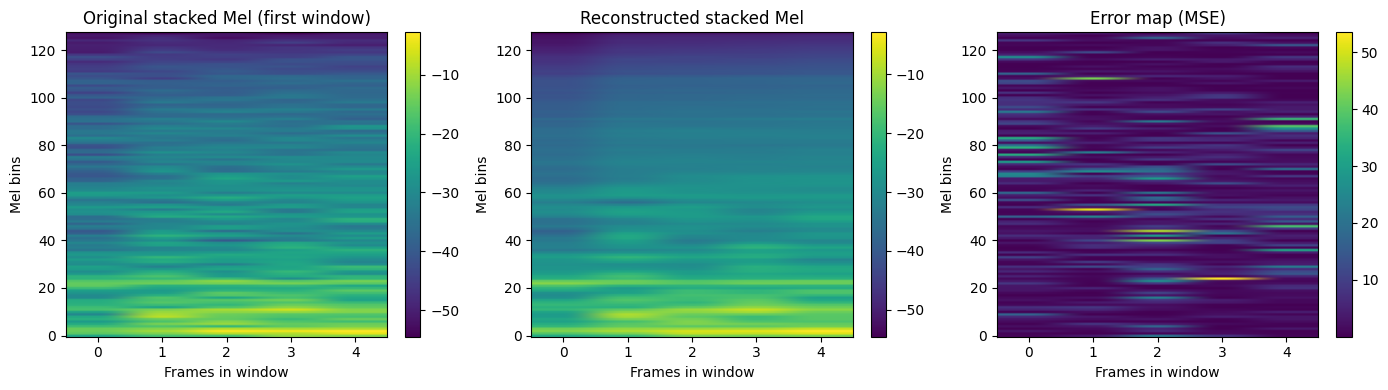

Worst-scoring file: anomaly_id_02_00000032.wav


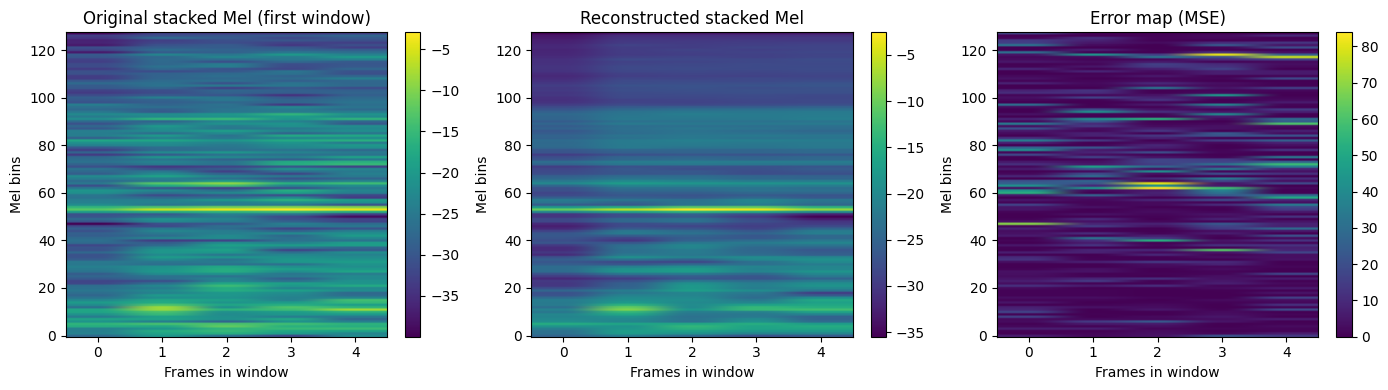

In [11]:
def visualize_triptych_fc(wav_path: Path, model: nn.Module, mean_vec: np.ndarray, std_vec: np.ndarray, n_frames=FRAME_STACK):
    """
    Show the first stacked-frame window as:
    - original Mel window
    - reconstructed Mel window
    - error map
    This helps you see where the model struggles.

    We:
    - compute Mel, stack frames
    - normalize a single vector with train mean/std
    - run AE forward
    - de-normalize and reshape back to [M, n_frames]
    """
    model.eval()

    # 1) Mel and stacked windows
    mel = wav_to_logmel(wav_path)                     # [M, T]
    X = stack_frames(mel, n_frames)                   # [N, D], D=M*n_frames
    if len(X) == 0:
        print("No segments found.")
        return
    x = X[0:1]                                        # pick first segment [1, D]

    # 2) Normalize
    x_norm = (x - mean_vec) / std_vec

    # 3) Run through model
    with torch.no_grad():
        x_t = torch.from_numpy(x_norm).to(DEVICE, dtype=torch.float32)
        y_t = model(x_t)
        y = y_t.detach().cpu().numpy()                # [1, D]

    # 4) De-normalize
    x_rec = y * std_vec + mean_vec                    # [1, D]
    x_orig = x                                        # [1, D]

    # 5) Reshape to [M, n_frames] for display
    M = N_MELS
    x_orig_2d = x_orig.reshape(1, M, n_frames)
    x_rec_2d  = x_rec.reshape(1, M, n_frames)
    err_2d    = (x_rec_2d - x_orig_2d) ** 2

    # 6) Plot three panels
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    im0 = axs[0].imshow(x_orig_2d[0], aspect="auto", origin="lower")
    axs[0].set_title("Original stacked Mel (first window)")
    fig.colorbar(im0, ax=axs[0], fraction=0.046)

    im1 = axs[1].imshow(x_rec_2d[0], aspect="auto", origin="lower")
    axs[1].set_title("Reconstructed stacked Mel")
    fig.colorbar(im1, ax=axs[1], fraction=0.046)

    im2 = axs[2].imshow(err_2d[0], aspect="auto", origin="lower")
    axs[2].set_title("Error map (MSE)")
    fig.colorbar(im2, ax=axs[2], fraction=0.046)

    for ax in axs: ax.set_xlabel("Frames in window"); ax.set_ylabel("Mel bins")
    plt.tight_layout()
    plt.show()

# Example: show a normal-ish and a worst-scoring file
visualize_triptych_fc(test_paths[0], model, ds_train_full.mean, ds_train_full.std, n_frames=FRAME_STACK)

scores_df = pd.DataFrame({"path": [str(p) for p in test_paths], "score": file_scores})
worst_path = Path(scores_df.sort_values("score", ascending=False).iloc[0]["path"])
print("Worst-scoring file:", worst_path.name)
visualize_triptych_fc(worst_path, model, ds_train_full.mean, ds_train_full.std, n_frames=FRAME_STACK)